In [11]:
import pandas as pd
import numpy as np
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Define the stock symbol and date range
symbol = 'CVX'
start_date = '2020-03-05'
end_date = '2021-09-01'

# Get the stock data
stock_data = yf.download(symbol, start=start_date, end=end_date)

# Prepare the data
data = stock_data['Close'].values
data = data.reshape(-1, 1)

# Scale the data
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

# Split the data into training and testing sets
train_size = int(len(data) * 0.80)
train_data, test_data = data[:train_size], data[train_size:]

# Convert the data into the appropriate format
def create_dataset(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size - 1):
        X.append(data[i:(i + window_size), 0])
        y.append(data[i + window_size, 0])
    return np.array(X), np.array(y)

window_size = 5
X_train, y_train = create_dataset(train_data, window_size)
X_test, y_test = create_dataset(test_data, window_size)

# Reshape the input data to match the RNN input format
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build the RNN model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(window_size, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2)

# Make predictions
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

# Invert the predictions to original scale
train_preds = scaler.inverse_transform(train_preds)
y_train = scaler.inverse_transform([y_train])
test_preds = scaler.inverse_transform(test_preds)
y_test = scaler.inverse_transform([y_test])

# Calculate the root mean squared error (RMSE) for model evaluation
train_rmse = np.sqrt(mean_squared_error(y_train[0], train_preds[:, 0]))
test_rmse = np.sqrt(mean_squared_error(y_test[0], test_preds[:, 0]))

print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')


[*********************100%***********************]  1 of 1 completed
Epoch 1/100
295/295 - 1s - loss: 0.0329 - 893ms/epoch - 3ms/step
Epoch 2/100
295/295 - 0s - loss: 0.0049 - 414ms/epoch - 1ms/step
Epoch 3/100
295/295 - 0s - loss: 0.0038 - 391ms/epoch - 1ms/step
Epoch 4/100
295/295 - 0s - loss: 0.0036 - 387ms/epoch - 1ms/step
Epoch 5/100
295/295 - 0s - loss: 0.0035 - 368ms/epoch - 1ms/step
Epoch 6/100
295/295 - 0s - loss: 0.0031 - 389ms/epoch - 1ms/step
Epoch 7/100
295/295 - 0s - loss: 0.0031 - 383ms/epoch - 1ms/step
Epoch 8/100
295/295 - 0s - loss: 0.0026 - 386ms/epoch - 1ms/step
Epoch 9/100
295/295 - 0s - loss: 0.0026 - 390ms/epoch - 1ms/step
Epoch 10/100
295/295 - 0s - loss: 0.0026 - 378ms/epoch - 1ms/step
Epoch 11/100
295/295 - 0s - loss: 0.0026 - 378ms/epoch - 1ms/step
Epoch 12/100
295/295 - 0s - loss: 0.0026 - 389ms/epoch - 1ms/step
Epoch 13/100
295/295 - 0s - loss: 0.0026 - 416ms/epoch - 1ms/step
Epoch 14/100
295/295 - 0s - loss: 0.0025 - 393ms/epoch - 1ms/step
Epoch 15/100
295

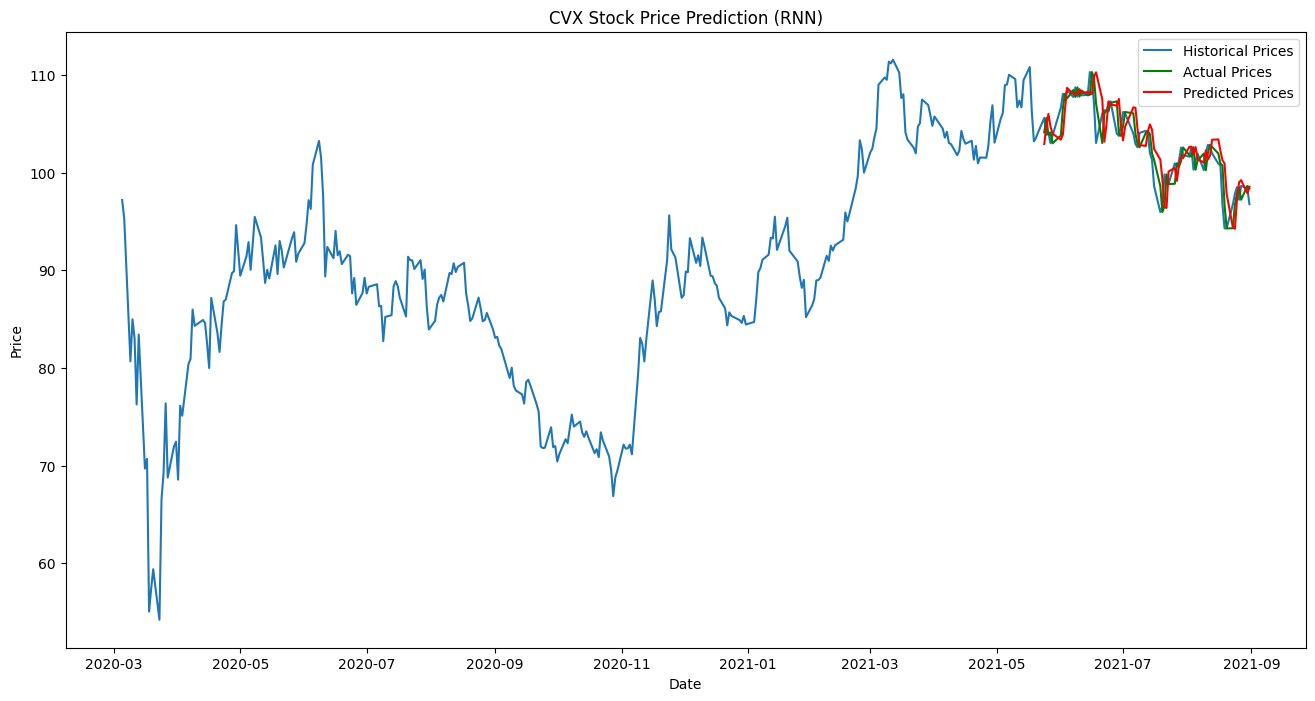

In [12]:
import matplotlib.pyplot as plt

# Get the dates for the predictions
pred_dates = stock_data.iloc[train_size+window_size+1:].index

# Combine the actual and predicted prices in a single DataFrame
actual_prices = pd.DataFrame(y_test.reshape(-1, 1), columns=['Actual'], index=pred_dates)
predicted_prices = pd.DataFrame(test_preds, columns=['Predicted'], index=pred_dates)
combined_prices = pd.concat([stock_data['Close'], actual_prices, predicted_prices], axis=1)

# Plot the actual and predicted prices on a graph
plt.figure(figsize=(16, 8))
plt.plot(combined_prices['Close'], label='Historical Prices')
plt.plot(combined_prices['Actual'], label='Actual Prices', color='green')
plt.plot(combined_prices['Predicted'], label='Predicted Prices', color='red')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'{symbol} Stock Price Prediction (RNN)')
plt.legend()
plt.show()


In [14]:
print("Predicted Stock Prices and Dates:\n")
for date, row in predicted_prices.iterrows():
    print(f"{date.strftime('%Y-%m-%d')}: {row['Predicted']:.2f}")


Predicted Stock Prices and Dates:

2021-05-24: 102.92
2021-05-25: 104.74
2021-05-26: 106.00
2021-05-27: 104.72
2021-05-28: 103.98
2021-06-01: 103.38
2021-06-02: 103.90
2021-06-03: 106.51
2021-06-04: 108.68
2021-06-07: 108.07
2021-06-08: 108.06
2021-06-09: 107.99
2021-06-10: 108.55
2021-06-11: 108.12
2021-06-14: 108.27
2021-06-15: 108.09
2021-06-16: 108.04
2021-06-17: 109.84
2021-06-18: 110.27
2021-06-21: 107.50
2021-06-22: 103.17
2021-06-23: 104.92
2021-06-24: 107.29
2021-06-25: 106.99
2021-06-28: 106.85
2021-06-29: 107.55
2021-06-30: 104.83
2021-07-01: 103.31
2021-07-02: 104.70
2021-07-06: 106.69
2021-07-07: 106.64
2021-07-08: 104.50
2021-07-09: 102.83
2021-07-12: 102.73
2021-07-13: 104.24
2021-07-14: 104.94
2021-07-15: 104.39
2021-07-16: 102.42
2021-07-19: 101.34
2021-07-20: 99.33
2021-07-21: 96.47
2021-07-22: 96.38
2021-07-23: 100.12
2021-07-26: 100.47
2021-07-27: 99.15
2021-07-28: 100.73
2021-07-29: 101.65
2021-07-30: 101.48
2021-08-02: 102.64
2021-08-03: 102.66
2021-08-04: 101.86
